**Imports**

In [0]:
# Importing modules
import pandas as pd
import os
import re
import nltk
nltk.download('words')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation as LDA

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


**Read sample reviews**

In [0]:

reviews = pd.read_csv('yelp_restaurant_reviews_sample.csv')
reviews.head(5)

review_id                 user_id  ... funny  cool
0  ApmUOTRfk3pB6USCiSHl0Q  LMxsgATZnl_Vw0Kze7HdQQ  ...  0     0   
1  TPBUEeKPKH1SfCDZQlFKkQ  UOKFUQlGWmMEjwiGFwACdQ  ...  0     1   
2  wdYB-bpUYt_lVodoKi56Ig  -od707p4FHGul0gte29AoQ  ...  0     0   
3  RMeMYKXgKjCa2gJ03APC7g  SdxHtbvFQJAgPUkQfE4CIQ  ...  1     0   
4  nXCAYS5UQnuw-CbhGnf5pQ  30SOROHP54Tn6ELl_YgeXg  ...  0     0   

[5 rows x 9 columns]

**Look at distribution of review rating**



In [0]:
reviews['stars'].value_counts()

5    37251
4    27817
3    14090
1    11395
2    9447 
Name: stars, dtype: int64

**Text cleaning**

In [0]:
words = set(nltk.corpus.words.words())
def keep_english_words(sentence):
  return " ".join(w for w in nltk.wordpunct_tokenize(sentence) \
                  if w.lower() in words or not w.isalpha())

reviews['text_processed'] = reviews['text'].map(lambda x: re.sub('[,\.!?\\n]', '', x))
reviews['text_processed'] = reviews['text_processed'].map(lambda x: x.lower())
reviews['text_processed'] = reviews['text_processed'].map(lambda x: keep_english_words(x))
# ?replace numbers with price

# Print out the first rows of papers
reviews['text_processed'].head(5)

0    had the cheese and a chai tea it was delicious and refreshing overall the service was great next time i ' m trying something different                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
1    after looking at the other about this restaurant i was not sure if would live up to my as seen from my review it really is a 5 star chilly is what we with to assorted parallel - ly hayward 5000 an beer chilly along with the green chilly sauc

**Word Cloud**

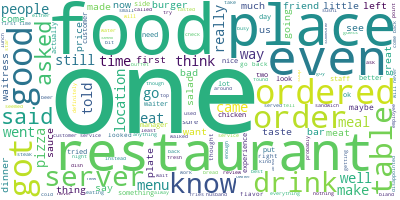

In [0]:
from wordcloud import WordCloud

negative_reviews = reviews[reviews['stars'] <= 2].reset_index(drop = True)

long_string = ','.join(list(negative_reviews['text_processed'] .values))
wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()


**Fit LDA model**

In [0]:
# Initialise the count vectorizer with the English stop words
n_features = 1000
n_samples = len(negative_reviews)
count_vectorizer = CountVectorizer(max_df=0.95, min_df=10,
                                max_features=n_features,
                                stop_words='english')

count_data = count_vectorizer.fit_transform(negative_reviews['text_processed'])

def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_topics = 5
number_words = 10

lda = LDA(n_components = number_topics,
          learning_method = 'batch',
          learning_decay = 0.7,
          max_iter = 5,
          verbose = 1,
          random_state = 0,
          n_jobs=-1)

print("Fitting LDA models with tf features, "
      "n_samples = %d and n_features = %d..."
      % (n_samples, n_features))

lda.fit(count_data)

print_topics(lda, count_vectorizer, number_words)


Fitting LDA models with tf features, n_samples=20842 and n_features=1000...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5

Topic #0:
food chicken good like ordered place just sauce rice service

Topic #1:
place like just food good don really ve burger time

Topic #2:
order food minutes time service said got told asked ordered

Topic #3:
food just place good pizza service restaurant time bar like

Topic #4:
food service table manager time restaurant came server did asked


**Check Dominant Topic in each document**

In [0]:
lda_output = lda.transform(count_data)
topicnames = ["Topic" + str(i) for i in range(number_topics)]
docnames = ["Doc" + str(i) for i in range(count_data.shape[0])]
df_document_topic_lda = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, 
                                 index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic_lda['dominant_topic'] = dominant_topic

df_document_topic_lda

Topic0  Topic1  Topic2  Topic3  Topic4  dominant_topic
Doc0      0.80    0.19    0.00    0.00    0.00    7             
Doc1      0.01    0.57    0.40    0.01    0.01    7             
Doc2      0.64    0.00    0.00    0.35    0.00    0             
Doc3      0.00    0.00    0.99    0.00    0.00    7             
Doc4      0.49    0.00    0.50    0.00    0.00    7             
...        ...     ...     ...     ...     ...   ..             
Doc20837  0.60    0.39    0.00    0.00    0.00    0             
Doc20838  0.00    0.07    0.00    0.92    0.00    0             
Doc20839  0.00    0.00    0.32    0.45    0.22    7             
Doc20840  0.72    0.01    0.01    0.25    0.01    0             
Doc20841  0.38    0.61    0.00    0.00    0.00    0             

[20842 rows x 6 columns]

In [0]:
pd.set_option('display.max_colwidth', -1)  

negative_reviews['text_processed'][3]

'beware of online ordersdon\'t get me wrong i love wingstop  back when i lived in texas they were everywhere  what i don\'t love is the online ordering system at this location  less than a month ago i placed an order for pick-up after i got off work  i go to pick it up right on timeand had to wait  35 minutes  what\'s the point of ordering online ahead of timefast forward to today when i placed an order to pick-up during my lunch break  i arrive and tell them i ordered online and gave them my name the response  "we only have one online order open did you order under the name caroline"  i show them my e-mail proving i ordered for pick-up at this locationthe cashier just kind of stared at me offering nothing but a 20 minute wait time to fry up a batch of wings  tl;dr don\'t order online here they\'ll screw it all up'

**Visualize the topics-keywords distribution.**

In [0]:
vis_data = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer)
pyLDAvis.display(vis_data)


/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


**Fit NMF Model**

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   
                                   max_features=n_features,
                                   stop_words='english')

tfidf_data = tfidf_vectorizer.fit_transform(negative_reviews['text_processed'])

nmf = NMF(n_components=7, 
          random_state=1,
          alpha=.1, 
          l1_ratio=.5)

nmf.fit(tfidf_data)

print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
print_topics(nmf, tfidf_vectorizer, number_words)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=20842 and n_features=1000...

Topic #0:
place like just good really don better ve didn sushi

Topic #1:
minutes table came server wait took asked waited waitress 10

Topic #2:
pizza crust cheese pizzas toppings delivery sauce wings ordered slice

Topic #3:
food service good bad slow terrible horrible great worst place

Topic #4:
chicken rice ordered fried sauce salad dry got flavor tasted

Topic #5:
order time customer called said manager location rude told wrong

Topic #6:
burger fries burgers cheese bun ordered sandwich bacon medium onion


**Normalize Topic weights and merge to original data**

In [0]:
from sklearn.preprocessing import normalize

nmf_output = nmf.transform(tfidf_data)

negative_reviews_f = pd.concat([negative_reviews, \
                                pd.DataFrame(normalize(nmf_output, norm='l1'), \
                                             columns = ['Topic 0', 'Topic 1',\
                                                        'Topic 2', 'Topic 3',\
                                                        'Topic 4', 'Topic 5',\
                                                        'Topic 6'])], axis=1)


**Verify on random samples to check if the topics make sense**

In [0]:
import random
num_samples = 2

random_index = random.sample(range(len(negative_reviews)), num_samples)
negative_reviews_f.iloc[random_index, [5,10,11,12,13,14,15,16]]

text  ...   Topic 6
12446  The service and ambiance are great. However, I am not big on steak and prefer chicken but I did try to eat many meats there. I wasn't too impressed especially with the limited chicken choices. It was just meat and to me, lacked variety or unique flavors which I thought they were supposed to have. I wouldn't spend this much money again. Some people may really enjoy but it just wasn't great for me. I did want to try the ribs but it never came to my table. The sausage wasn't anything great either and I love sausage.                                                                                                                                                                                                                                                                                 ...  0.000000
10913  The outside of our Tomahawk steak was burnt and the inside undercooked. The outside crust was not done right and the service was subpar with our server non attentive and even a bit passive aggressive. Perhaps it was because my partner and I were dressed casually in a tee shirt and jeans but with the bill hovering around $160 I still expected good service.\n\nThe fried calamari is dismissible and not fried crispy. The bacon is delicious however and I would recommend their portobello fries. It's just disappointing that their steak was cooked wrong and rather tasteless. Perhaps it was the thickness of the cut, but it's still surprising considering that's their main offering. Will likely not be coming back or recommending others to dine here. The venue and bathrooms are nice though.  ...  0.312179

[2 rows x 8 columns]

**Read and merge general business attributes**

In [0]:
business = pd.read_csv('./yelp_business.csv')

cols_to_keep = ['name', 'business_id','city','state', 'postal_code']
                                                            
negative_reviews_f = pd.merge(negative_reviews_f, business[cols_to_keep], \
                              left_on=['business_id'], right_on=['business_id'],\
                              how = 'left')

In [0]:
negative_reviews_f.head(2)

review_id                 user_id  ... state  postal_code
0  nXCAYS5UQnuw-CbhGnf5pQ  30SOROHP54Tn6ELl_YgeXg  ...  WI    53704      
1  J4W5WaPZSlMuakEsr9wUSw  HhXSYa7Wd0qRY_bRaAEfCw  ...  ON    L5R 3T7    

[2 rows x 21 columns]

In [0]:
negative_reviews_f.to_csv('./negative_reviews_w_topic.csv', index = False)

negative_

In [0]:
References
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
http://www.programmersought.com/article/6566770914/

https://medium.com/@Vishwacorp/nlp-analysis-of-yelp-restaurant-reviews-30b3d0e424a6
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
https://github.com/Vishwacorp/yelp_nlp/blob/f33f67e96bb0144fab3f4929aefb3f1c653d9248/1_extracting_reviews.ipynb